## Import Libraries 

In [1]:
import warnings
import sys
sys.path.insert(0, '../../src')
warnings.filterwarnings('ignore')

In [2]:
import ABC_train_test
import bostonDataset
import network
import dataset
import sanityChecks
import performanceMetrics
import torch 
from torch.utils.data import random_split 
import scrapbook as sb
from statistics import mean 

## Parameters
ABC-Generator parameters are as mentioned below: 
1. mean : 1 ($\beta \sim N(\beta^{*},\sigma)$ where $\beta^{*}$ are coefficients of statistical model) or 1 ($\beta \sim N(0,\sigma)$
2. std : $\sigma = 1, 0.1 , 0.01$ (standard deviation)

In [3]:
#ABC Generator Parameters
abc_mean = 1 
variance = 0.01

#Training parameters 
n_epochs = 5000

In [4]:
# Parameters
abc_mean = 1
variance = 0.01
n_epochs = 5000


## Dataset

In [5]:
#Parameters 
n_features = 13
n_samples= 506
n_target = 1 

In [6]:
X,Y = bostonDataset.boston_data()

# Train test split for dataset 
real_dataset = dataset.CustomDataset(X,Y)
train_size = round(0.8 * n_samples)
test_size = n_samples - train_size
train_data, test_data = random_split(real_dataset,[train_size,test_size])

        X1    X2    X3   X4     X5     X6    X7      X8   X9    X10   X11  \
0  0.00632  18.0  2.31  0.0  0.538  6.575  65.2  4.0900  1.0  296.0  15.3   
1  0.02731   0.0  7.07  0.0  0.469  6.421  78.9  4.9671  2.0  242.0  17.8   
2  0.02729   0.0  7.07  0.0  0.469  7.185  61.1  4.9671  2.0  242.0  17.8   
3  0.03237   0.0  2.18  0.0  0.458  6.998  45.8  6.0622  3.0  222.0  18.7   
4  0.06905   0.0  2.18  0.0  0.458  7.147  54.2  6.0622  3.0  222.0  18.7   

      X12   X13     Y  
0  396.90  4.98  24.0  
1  396.90  9.14  21.6  
2  392.83  4.03  34.7  
3  394.63  2.94  33.4  
4  396.90  5.33  36.2  


## Training Parameters 



In [7]:
batch_size = 100
#Select the device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### MSE Threshold and Mean Coeff Values 

Fetch coefficient values from stats model to be used in the ABC pre-generator 

Fetch MSE threshold for training the ABC-GAN 

The ABC-GAN will be trained until the threshold MSE is achieved or until it completes 5000 epochs 

The threshold mse is the mean mse of Catboost over 10 runs

In [8]:
books = sb.read_notebooks('./BaseLine_Model_Output')
catboostMSE = []
for nb in books.notebooks: 
    catboostMSE.append(nb.scraps['Catboost MSE'].data)
threshold_mse = mean(catboostMSE)

In [9]:
coeff = []
max_mse = 100
for nb in books.notebooks:
    if nb.scraps['Stats Model MSE'].data < max_mse:
        coeff = nb.scraps['Coefficients'].data

# ABC GAN Model

### Training the network
**Training ABC-GAN for n_epochs number of epochs** 

In [10]:
gen = network.Generator(n_features+1).to(device)
disc = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=0.01, betas=(0.5, 0.999))

In [11]:
discLossA1,genLossA1 = ABC_train_test.training_GAN(disc, gen,disc_opt,gen_opt,train_data,batch_size, n_epochs,criterion,coeff,mean,variance,device)

sb.glue("ABC_GAN_1 Generator Loss",genLossA1)
sb.glue("ABC_GAN_1 Discriminator Loss",discLossA1)

In [12]:
ABC_GAN1_metrics=ABC_train_test.test_generator(gen,test_data,coeff,mean,variance,device)

sb.glue("ABC_GAN_1 Metrics",ABC_GAN1_metrics)

#### Sanity Checks 

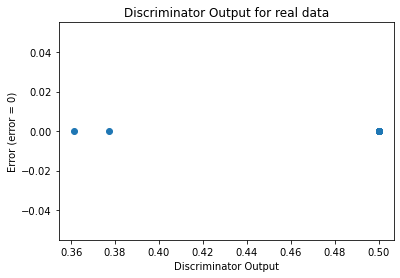

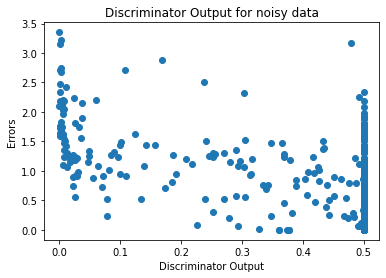

In [13]:
sanityChecks.discProbVsError(real_dataset,disc,device)

**Training ABC-GAN until mse of y_pred is > baseline_mse or n_epochs < 5000**

In [14]:
gen2 = network.Generator(n_features+1).to(device)
disc2 = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen2.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc2.parameters(), lr=0.01, betas=(0.5, 0.999))

In [15]:
discLossA2,genLossA2 = ABC_train_test.training_GAN_2(disc2,gen2,disc_opt,gen_opt,train_data,test_data,batch_size,threshold_mse,criterion,coeff,mean,variance,device)

sb.glue("ABC_GAN_2 Generator Loss",genLossA2)
sb.glue("ABC_GAN_2 Discriminator Loss",discLossA2)

Number of epochs 545


In [16]:
ABC_GAN2_metrics=ABC_train_test.test_generator_2(gen2,test_data,coeff,mean,variance,device)

sb.glue("ABC_GAN_2 Metrics",ABC_GAN2_metrics)

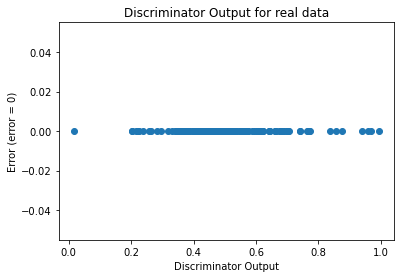

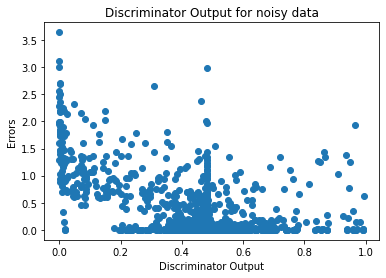

In [17]:
sanityChecks.discProbVsError(real_dataset,disc2,device)

# ABC - GAN Model with skip connection

In [18]:
gen3 = network.GeneratorWithSkipConnection(n_features+1).to(device)
disc3 = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen3.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc3.parameters(), lr=0.01, betas=(0.5, 0.999))

In [19]:
discLossA3,genLossA3 = ABC_train_test.training_GAN(disc3, gen3,disc_opt,gen_opt,train_data,batch_size, n_epochs,criterion,coeff,mean,variance,device)

sb.glue("ABC_GAN_3 Generator Loss",genLossA3)
sb.glue("ABC_GAN_3 Discriminator Loss",discLossA3)

In [20]:
ABC_GAN3_metrics=ABC_train_test.test_generator(gen3,test_data,coeff,mean,variance,device)

sb.glue("ABC_GAN_3 Metrics",ABC_GAN3_metrics)

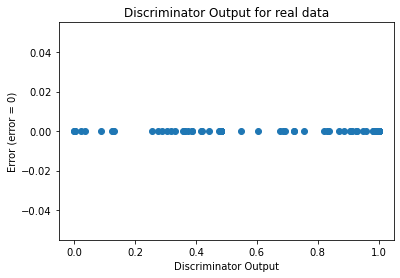

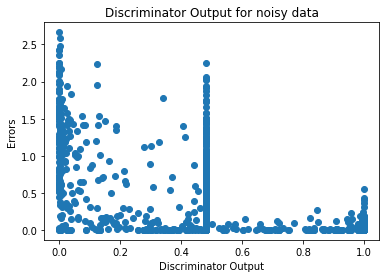

In [21]:
sanityChecks.discProbVsError(real_dataset,disc3,device)

## Skip Connection Model Analysis - ABC-GAN 

### Weight Analysis 

Study the weights of the skip connection layer

Equation of the skip connection is 

$output = y_{gan} * w + y_{abc} * (1-w)$

In [22]:
print("Weight of the node at skip connection")
for name,param in gen3.named_parameters():
    if(name == "skipNode.weight"):
        print(param)
        sb.glue("Skip Connection Weight",param.item())

Weight of the node at skip connection
Parameter containing:
tensor([[0.1960]], requires_grad=True)


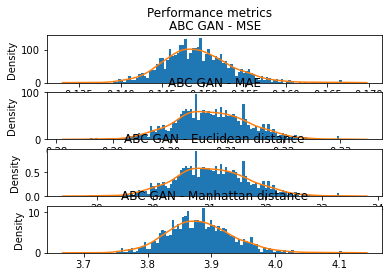

In [23]:
performanceMetrics.modelAnalysis2(ABC_GAN3_metrics)

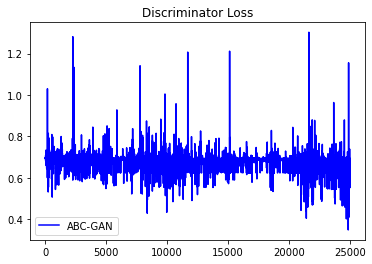

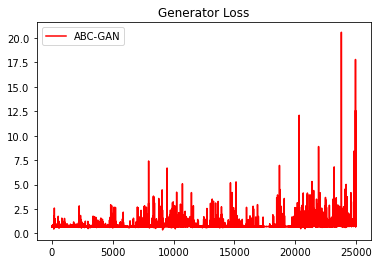

In [24]:
performanceMetrics.plotTrainingLoss2(discLossA3,genLossA3)